Dry adiabatic lapse rate is
$$
\Gamma_d \approx 9.8 K km^{-1}.
$$
Anything **less** is stable (or **more** if the lapse rate is taken **negative**).

In [1]:
cd /sata1_ceazalabs/arno/HPC/uvHome/

/sata1_ceazalabs/arno/HPC/uvHome


In [2]:
import pandas as pd
import xarray as xr
import numpy as np
from cartopy import crs
import matplotlib.pyplot as plt

import sys
sys.path.append('/sata1_ceazalabs/arno/HPC/uvHome/code/python')
import condor

hh = condor.module('helpers.py')
lapl = condor.module('laplace.py')

In [3]:
%matplotlib nbagg

In [4]:
D = pd.HDFStore('data/station_data_new.h5')

In [5]:
with pd.HDFStore('data/stations.h5') as S:
    sta = S['stations']

In [6]:
s = sta[(sta.lat.astype(float)>-33) & (sta.lat.astype(float)<-28)]

In [7]:
T2 = hh.stationize(D['ta_c'].xs('prom', 1, 'aggr').drop('10', 1, level='elev'))
T = xr.DataArray(T2, dims=('time', 'space')).dropna('time', 'all').dropna('space', 'all')
Z = xr.DataArray(s['elev'].to_frame(), dims=('space', 'var')).dropna('space').astype(float)

In [8]:
si = s.index.intersection(T.space)

In [9]:
Tr = T.sel(space=si).resample('h', 'time')

/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/bin/ipython:1: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="h").mean() 
  #!/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/bin/python
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/sata1_ceazalabs/arno/HPC/uvHome/miniconda3/envs/uv/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [32]:
lapl = condor.module('laplace.py')

In [33]:
L = lapl.LRLR(s, weights=lapl.LRLR.gauss(20000))

In [107]:
L.regress(Z, Tr.sel(time='2016-06'), 10000.)

In [104]:
p0 = L.p.sel(var='elev').values

In [106]:
p1 = L.p.sel(var='elev').values

In [65]:
ll = sta.loc[L.p.space][['lon', 'lat']].astype(float).as_matrix().T

In [75]:
count = Tr.sel(space=si).count('time')
count = count / count.max() * 50

In [41]:
coq = condor.Coquimbo()

<IPython.core.display.Javascript object>


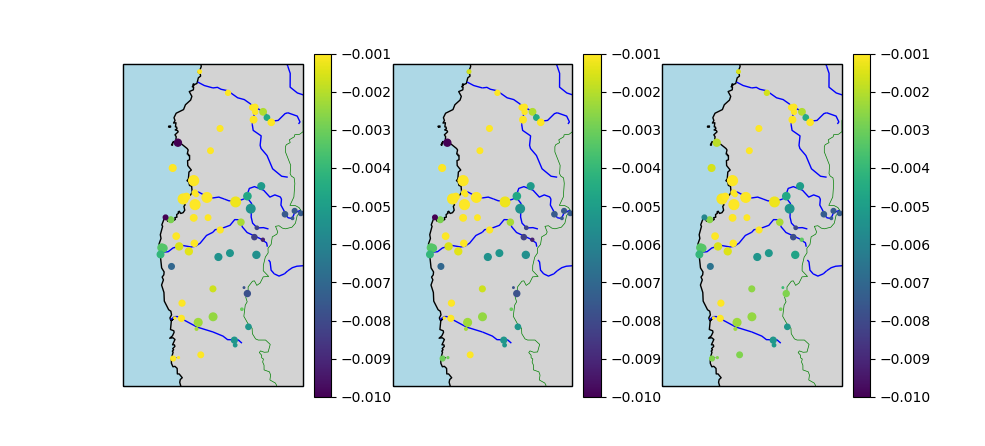

In [108]:
mi, ma = -0.01, -0.001

fig, axs = plt.subplots(1, 3, subplot_kw={'projection': crs.PlateCarree()})
plt.sca(axs[0])
plt.scatter(*ll, c=p0.flatten(), s=count, vmin=mi, vmax=ma, transform=crs.PlateCarree())
plt.colorbar()
coq(axs[0])

plt.sca(axs[1])
plt.scatter(*ll, c=p1.flatten(), s=count, vmin=mi, vmax=ma, transform=crs.PlateCarree())
plt.colorbar()
coq(axs[1])

plt.sca(axs[2])
plt.scatter(*ll, c=L.p.sel(var='elev').values.flatten(), s=count, vmin=mi, vmax=ma, transform=crs.PlateCarree())
plt.colorbar()
coq(axs[2])

In [39]:
reload(condor)

<module 'condor' from '/sata1_ceazalabs/arno/HPC/uvHome/code/python/condor.py'>

In [22]:
from scipy.sparse import csgraph

In [31]:
(lambda x: np.ones(x.shape))(L.L)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

<IPython.core.display.Javascript object>


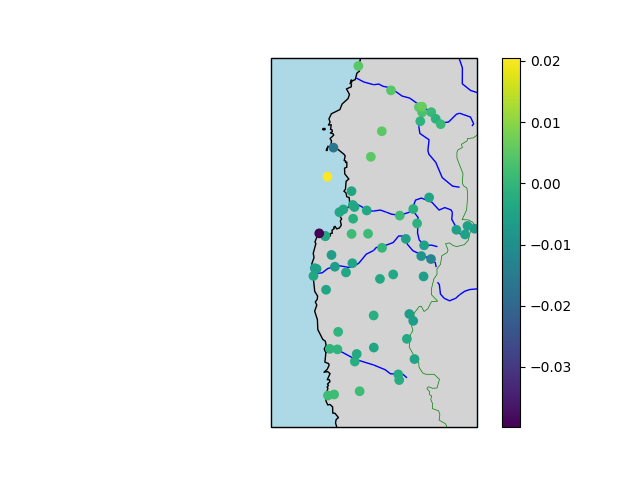

In [78]:
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs.PlateCarree()})
plt.scatter(*ll, c=p0.flatten(), transform=crs.PlateCarree())
plt.colorbar()
coq(axs)

In [128]:
x = Tr.sel(time='2016', space=s.index[s.index.str.contains('MET')])
x.coords['hour'] = ('time', x.time.dt.hour)

<IPython.core.display.Javascript object>


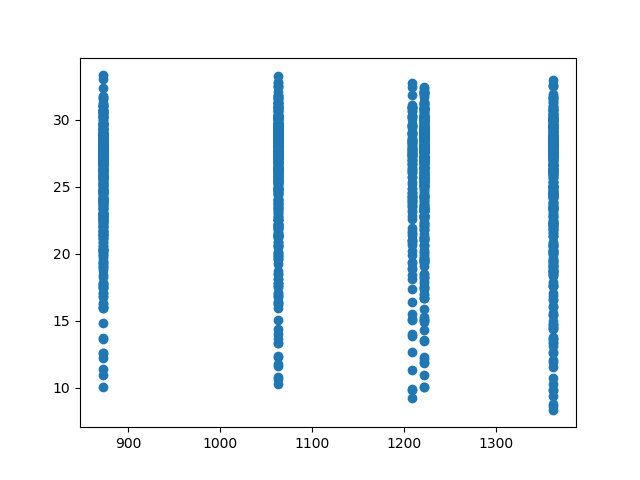

In [129]:
y = x[x.hour==12]
plt.figure()
plt.scatter(np.broadcast_to(Z.sel(space=s.index[s.index.str.contains('MET')]).T, y.shape), y)

In [111]:
s[s.index.str.contains('MET')]

,full,lon,lat,elev,first,last
station,,,,,,
MET3CH,Chiguinto,-70.32978,-28.83476,1063,2009-12-09 17:35:00,2017-09-24 00:00:00
MET3LA,La Arena,-70.27849,-28.91144,1209,2010-04-19 00:20:00,2017-09-24 00:00:00
MET3LH,La Huerta,-70.47333,-28.77642,872,2010-09-23 10:30:00,2017-09-24 00:00:00
MET3LM,La Mesilla,-70.43542,-28.83674,961,2009-12-09 17:45:00,2017-09-24 00:00:00
MET3LP,La Pampa,-70.22005,-28.97483,1363,2010-02-14 13:10:00,2017-09-24 00:00:00
MET3RM,Ramadilla,-70.43668,-28.77159,880,2009-12-09 17:40:00,2017-09-24 00:00:00
MET3SF,San Felix,-70.45712,-28.94014,1222,2010-01-06 12:50:00,2017-09-24 00:00:00


<IPython.core.display.Javascript object>


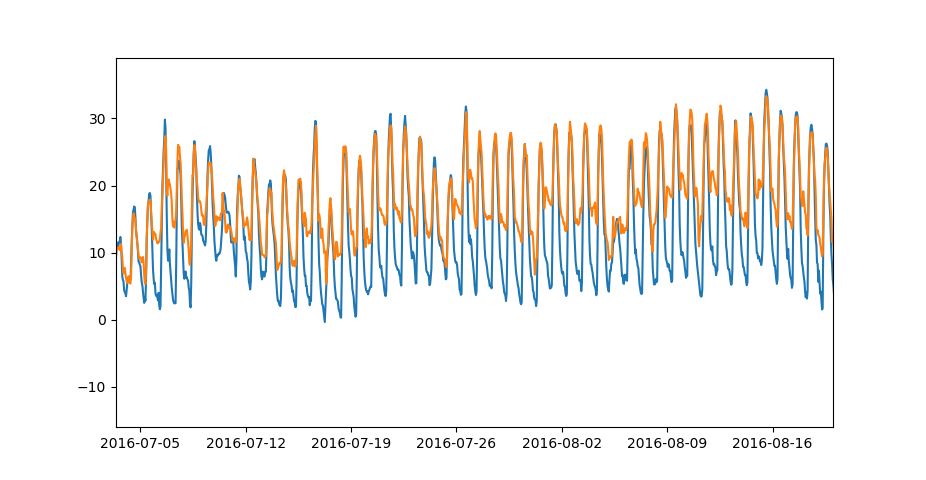

In [130]:
plt.figure()
plt.plot(x.time, x.sel(space='MET3LH').values)
plt.plot(x.time, x.sel(space='MET3CH').values)